In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from gtfparse import read_gtf

In [2]:
import gffutils
import pybedtools
from pybedtools.featurefuncs import TSS
from gffutils.helpers import asinterval
import bioframe as bf
from gtfparse import read_gtf

# Inspecting relationship of distal enhancers with DEGs for other datasets

***Purpose:*** Because we have been able to replicate some results using the DESeq DE genes (Fig 6B: CTCF-binding patterns around the TSS), but not the distal enhancer binding (Fig 6D), I want to re-visit it to follow the process with the data from the original paper in order to replicate their findings.

The original code used:
https://gist.github.com/golobor/66ddc479c460ec128e85b58ba6ec2f91#file-2015-11-23-ctcf-nora-expression-genes-ipynb 

### Loading TSS data for mm10 genome -- used for kallisto alignment for both dNipbL and dWapL

In [3]:
# Reading gtf file that contains only the parsed TSSes, generated from default gff_utils
tss_df = read_gtf('/project/fudenber_735/genomes/mm10/ensembl/tsses.gtf')

# cleaning out less-well defined chromosome numbers
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('NT_'))]
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('MT'))]

# paste 'chr' to all chromosome names
tss_df["seqname"] = 'chr' + tss_df["seqname"]

# rename column to chrom to match bedframe/bioframe format
tss_df = tss_df.rename(columns= {"seqname" : "chrom"})

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'ccds_id']


In [4]:
# Removing pseudo chromosomes
before = len(tss_df)
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrGL'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrJH'))]
after = len(tss_df)

print("Removed " + str(before-after) + " rows.")

Removed 95 rows.


## dWapL

In [276]:
# data for wapl
proj = "/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929/"

# s2c to collapse tpm into averages
s2c = pd.read_csv(proj+"s2c.tsv", index_col = 0, sep='\t')

# t2g to compare gene-level analysis
t2g = pd.read_csv("/project/fudenber_735/genomes/mm10/ensembl/ensembl_relational_downloads/biomaRt_mm10_t2g.csv", index_col = 0)

In [277]:
# # To extract the coordinates from the DE table into bedframe format 
# (for now, keeping them in there)
#fpkm[['chrom', 'start', 'end']] = fpkm['locus'].str.split(':|-', expand=True)

In [278]:
conditions = s2c['condition'].unique()

# formatting because dashes were removed when working in R
conditions = [x.strip().replace("-","_") for x in conditions]

# removing PT type for now (treating as a separate experiment)
conditions = [x for x in conditions if 'Wapl' in x ]

conditions

['Wapl_C20_96h', 'Wapl_C20_48h', 'Wapl_C20_24h', 'Wapl_C20_6h', 'Wapl_C20_0h']

In [279]:
# import DEseq results

# base condition
base_level='Wapl_C20_0h'

# Importing the .csv outputs from sleuth WT for each of the conditions into pandas dataframes:
deseq_results = {}

folder = proj+"deseq-mm10-results/"

for c in conditions:
    
    if c == base_level:
        continue
        
    df = pd.read_csv(folder+"pairwise_deseq_wt_"+c+".csv", index_col = 0)
    deseq_results[c] = df

dict_keys(['Wapl_C20_96h', 'Wapl_C20_48h', 'Wapl_C20_24h', 'Wapl_C20_6h'])

In [ ]:
# # store each result into a dict to keep in one object 
# result_keys = [x for x in list(deseq_results.keys())]
# basic_deseq_results = {condition: deseq_results[condition] for condition in result_keys }
# basic_deseq_results.keys()

### Adding TSS annotation to each row in deseq_results

In [281]:
ts_intervals = tss_df[['gene_id','start', 'end']].drop_duplicates(['gene_id'])
ts_intervals.shape

(55364, 3)

In [282]:
print(basic_deseq_results['Wapl_C20_6h'].shape)

(29723, 6)


In [283]:
basic_deseq_results['Wapl_C20_96h']['baseMean'].isna().sum()

0

In [284]:
# drop duplicate TSSes
ts_intervals = tss_df[['gene_id','chrom', 'start', 'end']].drop_duplicates(['gene_id'])

# add a TSS to each gene_id in all the results DFs
for k in basic_deseq_results.keys():
    
    # drop gene from data field if there is no change associated
    basic_deseq_results[k].dropna(subset=['log2FoldChange'], inplace=True)

    basic_deseq_results[k] = basic_deseq_results[k].merge(ts_intervals, left_index=True, right_on='gene_id', how='left')
    #basic_deseq_results[k].set_index('gene_id', inplace=True)
    
    # Checking if any of the significant genes will be lost due to loss of TSS annotation
    print("Checking for lost significant genes for condition: ", k)
    ix = np.where(basic_deseq_results[k]['start'].isna() & (basic_deseq_results[k]['padj'] < 0.05))
    print("lost: ", str(basic_deseq_results[k].iloc[ix].shape[0]))
    
    # If could not find a TSS, drop entire row
    basic_deseq_results[k].dropna(subset=['start'], inplace=True)

Checking for lost significant genes for condition:  Wapl_C20_96h
lost:  34
Checking for lost significant genes for condition:  Wapl_C20_48h
lost:  8
Checking for lost significant genes for condition:  Wapl_C20_24h
lost:  1
Checking for lost significant genes for condition:  Wapl_C20_6h
lost:  0


In [285]:
# printing to see how many datapoints were lost from dropping
print(basic_deseq_results['Wapl_C20_6h'].shape)

(20256, 10)


In [286]:
# enhancer coordinates -- the set that were above 80%, that had been liftover from mm10
enhancer_coords = bf.read_table('/project/fudenber_735/collaborations/karissa_2022/features/mm10/mESC_Enhancer_prediction_Chen12_BMCgenomics_mm10_liftover_above8.bed',
                               schema='bed5')


In [287]:
# Adding distance to closest enhancer to all genes in set of results tables
for k in basic_deseq_results.keys():
    
    # find closest intervals
    closest_intervals = bf.closest(bf.sanitize_bedframe(basic_deseq_results[k]), enhancer_coords, suffixes=('', '_enh'), k=1)
    
    # add the distance column to the DE results table
    basic_deseq_results[k] = pd.merge(basic_deseq_results[k], closest_intervals[['gene_id', 'distance']], on='gene_id', how='left')
    
    print('Number of genes with no closest enhancer for condition: ', k) 
    print(basic_deseq_results[k]['distance'].isna().sum())
    

Number of genes with no closest enhancer for condition:  Wapl_C20_96h
11
Number of genes with no closest enhancer for condition:  Wapl_C20_48h
11
Number of genes with no closest enhancer for condition:  Wapl_C20_24h
11
Number of genes with no closest enhancer for condition:  Wapl_C20_6h
11


In [289]:
# average distance?
np.mean(basic_deseq_results['Wapl_C20_6h']['distance'])

1409794.9267473451

(array([7.103e+03, 3.780e+03, 2.290e+03, 1.590e+03, 1.047e+03, 7.950e+02,
        6.840e+02, 5.970e+02, 5.290e+02, 3.610e+02, 2.300e+02, 2.050e+02,
        1.740e+02, 1.450e+02, 1.140e+02, 9.000e+01, 7.100e+01, 3.600e+01,
        3.200e+01, 1.500e+01, 2.500e+01, 2.600e+01, 5.000e+00, 1.300e+01,
        1.500e+01, 2.200e+01, 1.700e+01, 1.400e+01, 8.000e+00, 6.000e+00,
        3.000e+00, 8.000e+00, 1.300e+01, 1.600e+01, 3.400e+01, 2.800e+01,
        1.100e+01, 1.700e+01, 2.700e+01, 9.000e+00, 9.000e+00, 3.000e+00,
        4.000e+00, 4.000e+00, 4.000e+00, 2.000e+00, 4.000e+00, 4.000e+00,
        4.000e+00, 2.000e+00]),
 array([0.0, 399372.24, 798744.48, 1198116.72, 1597488.96, 1996861.2,
        2396233.44, 2795605.6799999997, 3194977.92, 3594350.16, 3993722.4,
        4393094.64, 4792466.88, 5191839.12, 5591211.359999999, 5990583.6,
        6389955.84, 6789328.08, 7188700.32, 7588072.56, 7987444.8,
        8386817.04, 8786189.28, 9185561.52, 9584933.76, 9984306.0,
        10383678.24, 10

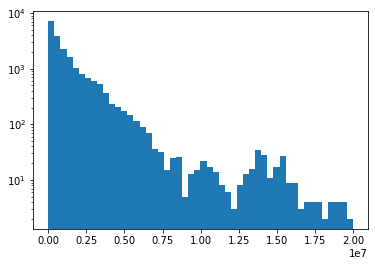

In [306]:
plt.hist(basic_deseq_results['Wapl_C20_6h']['distance'].dropna(), bins=50, log=True)

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:484: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:484: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:484: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:484: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:484: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, 

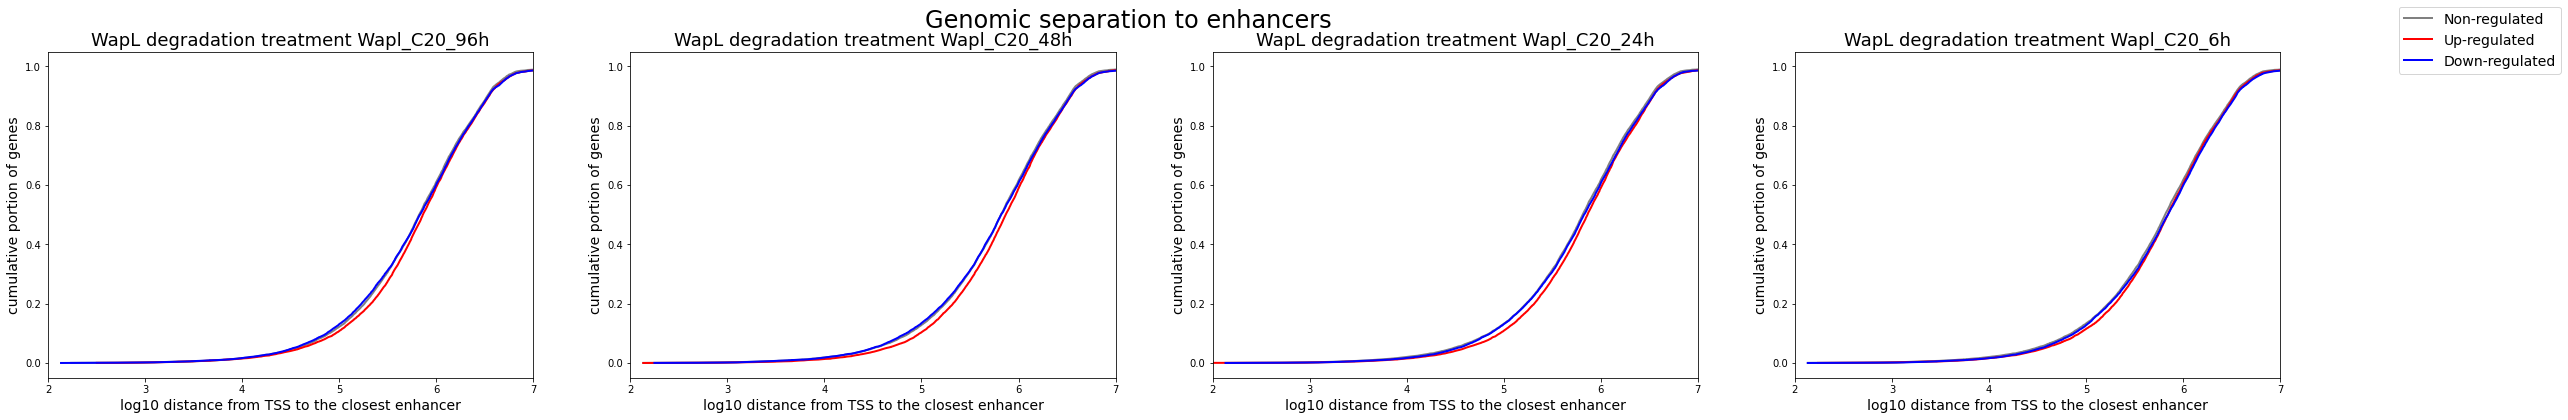

In [303]:
plot_enhancer_deseq_resultDict(basic_deseq_results, 0.05, "WapL degradation treatment ")

In [302]:
def plot_enhancer_deseq_resultDict(de_results, pval_cutoff, subtitle_prefix):

    conditions = de_results.keys()

    # Generating a subplot for each of the conditions
    num_plots = len(conditions)
    fig, axs = plt.subplots(1, num_plots, figsize=[num_plots*10, 6])
    fig.suptitle("Genomic separation to enhancers", fontsize=24)

    for cond, ax in zip(conditions, axs.ravel()):
        
        # result set for this particular condition
        res = de_results[cond].dropna(subset=['distance'])
        
        # Extracting significantly DE transcripts
        sig_DE = res[res['padj'] < pval_cutoff]
        up_reg = res[res['log2FoldChange'] > 0]
        down_reg = res[res['log2FoldChange'] <= 0]

        # Will also look at enrichment around transcripts that were in RNAseq dataset that did not have significant DE
        non_reg = res[res['padj'] >= pval_cutoff]

        # generate y axis: cumulative proportion of genes
        cum_all = np.arange(0, len(non_reg), 1)
        cum_all = cum_all/ len(non_reg)

        # plotting 
        ax.plot(np.log10(non_reg['distance'].sort_values()), 
                cum_all, 
                color='grey',
                label='Non-regulated',
                linewidth=2)


        # generate y axis: cumulative proportion of genes
        cum_up = np.arange(0, len(up_reg), 1)
        cum_up = cum_up/ len(up_reg)

        ax.plot(np.log10(up_reg['distance'].sort_values()), 
                cum_up, 
                color='red', 
                label='Up-regulated',
                linewidth=2)

        # generate y axis: cumulative proportion of genes
        cum_down = np.arange(0, len(down_reg), 1)
        cum_down = cum_down/ len(down_reg)

        ax.plot(np.log10(down_reg['distance'].sort_values()),
                cum_down,
                color='blue',
                label='Down-regulated',
                linewidth=2)

        ax.set_title(subtitle_prefix + cond, fontsize=18)
        ax.set_xlabel("log10 distance from TSS to the closest enhancer", fontsize=14)
        ax.set_ylabel("cumulative portion of genes", fontsize=14)
        ax.set_xlim([2, 7])


    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=14)
    plt.show()
    

### Possible Next Steps:

- Repeat the above distal enhancer mapping for dNipbL
    - still use DESeq2?
- Repeat the above using Super-Enhancers
- Do an analysis of active histone markings for promoter/enhancers (Liu 2020 Suppl. figure 4)
    - first, for dWapL (just re-capitulate)
    - then, dCTCF (? does this make sense to do?)